Import libraries

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("muted")

Load the training and testing set

In [72]:
training_set  = pd.read_csv("dataset/train.csv")
testing_set = pd.read_csv("dataset/test.csv")

In [73]:
training_set.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [74]:
testing_set.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [75]:
training_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [76]:
testing_set.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

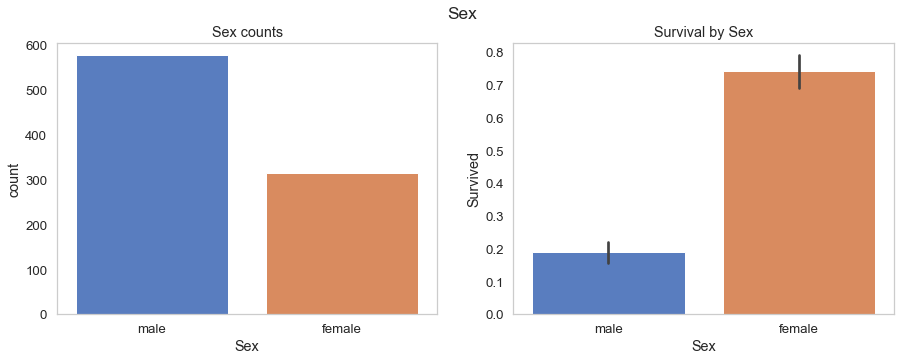

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Sex')

sns.countplot(ax=axes[0], x='Sex', data=training_set)
axes[0].set_title('Sex counts')

sns.barplot(ax=axes[1], x='Sex', y='Survived', data=training_set)
axes[1].set_title('Survival by Sex');

Impute missing data in embarked column

In [78]:
training_set.groupby('Embarked').size()

Embarked
C    168
Q     77
S    644
dtype: int64

In [79]:
training_set['Embarked'].fillna('S', inplace=True)

In [80]:
imputer = KNNImputer(n_neighbors=3)
training_set['Age'] = imputer.fit_transform(training_set[['Age']]).ravel()
testing_set['Age'] = imputer.fit_transform(testing_set[['Age']]).ravel()

In [81]:
drop_column = ['PassengerId', 'Name', 'Cabin', 'Ticket']
training_set_copy = training_set.drop(drop_column, axis=1)
testing_set_copy = testing_set.drop(drop_column, axis=1)

In [82]:
training_set_copy.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [83]:
testing_set_copy.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64

In [84]:
training_set_copy.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [85]:
label_encoder = LabelEncoder()
training_set_copy['Sex'] = label_encoder.fit_transform(training_set_copy['Sex'])
training_set_copy['Embarked'] = label_encoder.fit_transform(training_set_copy['Embarked'])
training_set_copy.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,2
1,1,1,0,38.000000,1,0,71.2833,0
2,1,3,0,26.000000,0,0,7.9250,2
3,1,1,0,35.000000,1,0,53.1000,2
4,0,3,1,35.000000,0,0,8.0500,2
5,0,3,1,29.699118,0,0,8.4583,1
6,0,1,1,54.000000,0,0,51.8625,2
7,0,3,1,2.000000,3,1,21.0750,2
8,1,3,0,27.000000,0,2,11.1333,2
9,1,2,0,14.000000,1,0,30.0708,0


In [86]:
X_train = training_set_copy.iloc[:, 1:]
y_train = training_set_copy.iloc[:, :1]

In [87]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [88]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayesian', GaussianNB()),
    ('Support Vector Machine', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier())]

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.3f}, {cv_results.std():.3f}")

Logistic Regression: 0.792, 0.029
KNN: 0.798, 0.032
Naive Bayesian: 0.789, 0.023
Support Vector Machine: 0.826, 0.044
Decision Tree: 0.778, 0.031
Random Forest: 0.804, 0.035


## Fine Tuning

In [89]:
clf = SVC()

rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
rand_search = RandomizedSearchCV(clf, param_distributions = rand_list, n_iter = 20, n_jobs = 4, cv = 10, random_state = 42, scoring = 'accuracy') 
rand_search.fit(X_train, y_train.values.ravel()) 
rand_search.best_params_

{'C': 5.046137691733707, 'gamma': 0.19767211400638388}

In [90]:
pred = rand_search.predict(X_train)

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_train, pred)
acc

0.8597081930415263